In [1]:
import os
#go back one directory
os.chdir("..")
# now go into source directory
os.chdir("source")


In [2]:
from tools.spaceX_ephem_tools import spacex_ephem_to_dataframe, parse_spacex_datetime_stamps, read_spacex_ephemeris, spacex_ephem_to_dataframe
from tools.utilities import yyyy_mm_dd_hh_mm_ss_to_jd, jd_to_utc

In [3]:
import pandas as pd
import numpy as np

In [4]:
def std_dev_from_lower_triangular(lower_triangular_data):
    cov_matrix = np.zeros((6, 6))
    row, col = np.tril_indices(6)
    cov_matrix[row, col] = lower_triangular_data
    cov_matrix = cov_matrix + cov_matrix.T - np.diag(cov_matrix.diagonal())
    std_dev = np.sqrt(np.diag(cov_matrix))
    return std_dev

def spacex_ephem_to_df_w_cov(ephem_path: str) -> pd.DataFrame:
    """
    Convert SpaceX ephemeris data, including covariance terms, into a pandas DataFrame.

    Parameters
    ----------
    ephem_path : str
        Path to the ephemeris file.

    Returns
    -------
    pd.DataFrame
        DataFrame containing parsed SpaceX ephemeris data, including covariance terms.
    """
    with open(ephem_path) as f:
        lines = f.readlines()

    # Remove header lines and select every 4th line starting from the first data line
    t_xyz_uvw = lines[4::4]

    # Extract t, x, y, z, u, v, w
    t = [float(i.split()[0]) for i in t_xyz_uvw]
    x = [float(i.split()[1]) for i in t_xyz_uvw]
    y = [float(i.split()[2]) for i in t_xyz_uvw]
    z = [float(i.split()[3]) for i in t_xyz_uvw]
    u = [float(i.split()[4]) for i in t_xyz_uvw]
    v = [float(i.split()[5]) for i in t_xyz_uvw]
    w = [float(i.split()[6]) for i in t_xyz_uvw]

    # Extract the 21 covariance terms (3 lines after each primary data line)
    covariance_data = {f'cov_{i+1}': [] for i in range(21)}
    for i in range(5, len(lines), 4):  # Start from the first covariance line
        cov_lines = lines[i:i+3]  # Get the three lines of covariance terms
        cov_values = ' '.join(cov_lines).split()
        for j, value in enumerate(cov_values):
            covariance_data[f'cov_{j+1}'].append(float(value))

    # Convert timestamps to strings and call parse_spacex_datetime_stamps
    t_str = [str(int(i)) for i in t]  # Convert timestamps to string
    parsed_timestamps = parse_spacex_datetime_stamps(t_str)

    # Calculate Julian Dates for each timestamp
    jd_stamps = np.zeros(len(parsed_timestamps))
    for i in range(len(parsed_timestamps)):
        jd_stamps[i] = yyyy_mm_dd_hh_mm_ss_to_jd(int(parsed_timestamps[i][0]), int(parsed_timestamps[i][1]), 
                                                 int(parsed_timestamps[i][2]), int(parsed_timestamps[i][3]), 
                                                 int(parsed_timestamps[i][4]), int(parsed_timestamps[i][5]), 
                                                 int(parsed_timestamps[i][6]))

    # Initialize lists for averaged position and velocity standard deviations
    sigma_positions = []
    sigma_velocities = []

    # Calculate averaged standard deviations for each row
    for _, row in pd.DataFrame(covariance_data).iterrows():
        std_devs = std_dev_from_lower_triangular(row.values)
        sigma_position = np.mean(std_devs[:3])  # Assuming I can average uncertainty in x, y, z
        sigma_velocity = np.mean(std_devs[3:])  # Assuming I can average uncertainty in u, v, w
        sigma_positions.append(sigma_position)
        sigma_velocities.append(sigma_velocity)

    # Construct the DataFrame with all data
    spacex_ephem_df = pd.DataFrame({
        't': t,
        'x': x,
        'y': y,
        'z': z,
        'u': u,
        'v': v,
        'w': w,
        'JD': jd_stamps,
        'sigma_pos': sigma_positions,
        'sigma_vel': sigma_velocities,
        **covariance_data
    })

    spacex_ephem_df['hours'] = (spacex_ephem_df['JD'] - spacex_ephem_df['JD'][0]) * 24 # hours since first timestamp
    # calculate UTC time by applying jd_to_utc() to each JD value
    spacex_ephem_df['UTC'] = spacex_ephem_df['JD'].apply(jd_to_utc)
    # TODO: I am gaining 3 milisecond per minute in the UTC time. Why?

    return spacex_ephem_df

In [5]:
spacex_ephem_dfwcov = spacex_ephem_to_df_w_cov("/Users/charlesc/Documents/GitHub/ERP_tools/external/ephems/starlink/MEME_57632_STARLINK-30309_3530645_Operational_1387262760_UNCLASSIFIED.txt")

In [6]:
(spacex_ephem_dfwcov['UTC'][4])

Timestamp('2023-12-19 06:49:41.999999')

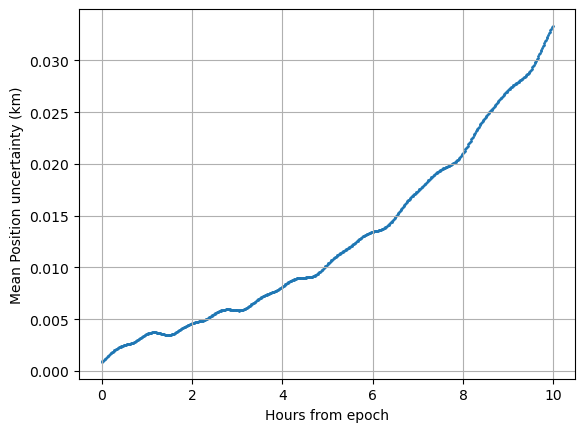

In [7]:
spacex_ephem_dfwcov.head()
import matplotlib.pyplot as plt

#calculate hours from start using spacex_ephem_dfwcov['JD']
plt.scatter(spacex_ephem_dfwcov['hours'][0:600],spacex_ephem_dfwcov['sigma_pos'][0:600], s=1)
plt.xlabel('Hours from epoch')
plt.ylabel('Mean Position uncertainty (km)')
plt.grid()
# plt.plot(spacex_ephem_dfwcov['JD'],spacex_ephem_dfwcov['sigma_vel'])

In [8]:
from orekit.pyhelpers import datetime_to_absolutedate
from org.orekit.estimation.measurements import PV, ObservableSatellite
from org.hipparchus.geometry.euclidean.threed import Vector3D
from org.orekit.time import AbsoluteDate
from datetime import datetime
from datetime import timedelta

spacex_ephem_dfwcov = spacex_ephem_to_df_w_cov("/Users/charlesc/Documents/GitHub/ERP_tools/external/ephems/starlink/MEME_57632_STARLINK-30309_3530645_Operational_1387262760_UNCLASSIFIED.txt")

sat_list = {    
    'STARLINK-30309': {
        'norad_id': 57632,  # For Space-Track TLE queries
        'cospar_id': '2023-122A',  # For laser ranging data queries
        'sic_id': '000',  # For writing in CPF files
        'mass': 800.0, # kg; v2 mini
        'cross_section': 100.0, # m2; TODO: get proper value
        'cd': 1.5, # TODO: compute proper value
        'cr': 1.0  # TODO: compute proper value
    }
}

sc_name = 'STARLINK-30309'  # Change the name to select a different satellite in the dict


range_weight = 1.0 # Will be normalized later (i.e divided by the number of observations)
range_sigma = 1.0 # Estimated covariance of the range measurements, in meters

odDate = datetime(2023, 12, 19, 6, 45, 42, 00000)
collectionDuration = 1 * 1/24 * 1/60 * 5 # 5 minutes
startCollectionDate = odDate + timedelta(days=-collectionDuration)

#Get TLE for first guess
import spacetrack
# Space-Track
identity_st = input('Enter SpaceTrack username')
import getpass
password_st = getpass.getpass(prompt='Enter SpaceTrack password for account {}'.format(identity_st))
import spacetrack.operators as op
from spacetrack import SpaceTrackClient
st = SpaceTrackClient(identity=identity_st, password=password_st)

rawTle = st.tle(norad_cat_id=sat_list[sc_name]['norad_id'], epoch='<{}'.format(odDate), orderby='epoch desc', limit=1, format='tle')
tleLine1 = rawTle.split('\n')[0]
tleLine2 = rawTle.split('\n')[1]
print(tleLine1)
print(tleLine2)

1 57632U 23122A   23352.63911708  .00000218  00000-0  31199-4 0  9991
2 57632  42.9989 187.4819 0001540 218.5126 141.5607 15.02543113 20000


In [9]:
# Orbit propagator parameters
prop_min_step = 0.001 # s
prop_max_step = 300.0 # s
prop_position_error = 5.0 # m

# Estimator parameters
estimator_position_scale = 1.0 # m
estimator_convergence_thres = 1e-3
estimator_max_iterations = 25
estimator_max_evaluations = 35

from org.orekit.utils import Constants as orekit_constants
from org.orekit.frames import FramesFactory, ITRFVersion
from org.orekit.utils import IERSConventions
tod = FramesFactory.getTOD(IERSConventions.IERS_2010, False) # Taking tidal effects into account when interpolating EOP parameters
gcrf = FramesFactory.getGCRF()
itrf = FramesFactory.getITRF(IERSConventions.IERS_2010, False)

# Selecting frames to use for OD
eci = gcrf
ecef = itrf

from org.orekit.models.earth import ReferenceEllipsoid
wgs84Ellipsoid = ReferenceEllipsoid.getWgs84(ecef)
from org.orekit.bodies import CelestialBodyFactory
moon = CelestialBodyFactory.getMoon()
sun = CelestialBodyFactory.getSun()

from org.orekit.time import AbsoluteDate, TimeScalesFactory
utc = TimeScalesFactory.getUTC()
mjd_utc_epoch = AbsoluteDate(1858, 11, 17, 0, 0, 0.0, utc)

from org.orekit.propagation.analytical.tle import TLE
orekitTle = TLE(tleLine1, tleLine2)

from org.orekit.attitudes import NadirPointing
nadirPointing = NadirPointing(eci, wgs84Ellipsoid)

from org.orekit.propagation.analytical.tle import SGP4
sgp4Propagator = SGP4(orekitTle, nadirPointing, sat_list[sc_name]['mass'])

tleInitialState = sgp4Propagator.getInitialState()
tleEpoch = tleInitialState.getDate()
tleOrbit_TEME = tleInitialState.getOrbit()
tlePV_ECI = tleOrbit_TEME.getPVCoordinates(eci)

from org.orekit.orbits import CartesianOrbit
tleOrbit_ECI = CartesianOrbit(tlePV_ECI, eci, wgs84Ellipsoid.getGM())

from org.orekit.propagation.conversion import DormandPrince853IntegratorBuilder
integratorBuilder = DormandPrince853IntegratorBuilder(prop_min_step, prop_max_step, prop_position_error)

from org.orekit.propagation.conversion import NumericalPropagatorBuilder
from org.orekit.orbits import PositionAngleType


In [16]:
propagatorBuilder = NumericalPropagatorBuilder(tleOrbit_ECI,
                                               integratorBuilder, PositionAngleType.MEAN, estimator_position_scale)
propagatorBuilder.setMass(sat_list[sc_name]['mass'])
propagatorBuilder.setAttitudeProvider(nadirPointing)

from org.orekit.forces.gravity.potential import GravityFieldFactory
from org.orekit.forces.gravity import HolmesFeatherstoneAttractionModel, ThirdBodyAttraction, Relativity
from org.orekit.forces.radiation import SolarRadiationPressure, IsotropicRadiationSingleCoefficient
from org.orekit.models.earth.atmosphere.data import MarshallSolarActivityFutureEstimation
from org.orekit.models.earth.atmosphere import DTM2000
from org.orekit.forces.drag import DragForce, IsotropicDrag

def configure_force_models(propagatorBuilder, enable_gravity=True, enable_third_body=True,
                           enable_solar_radiation=True, enable_relativity=True, enable_atmospheric_drag=True):
    # Earth gravity field with degree 64 and order 64
    if enable_gravity:
        gravityProvider = GravityFieldFactory.getNormalizedProvider(10, 10)
        gravityAttractionModel = HolmesFeatherstoneAttractionModel(ecef, gravityProvider)
        propagatorBuilder.addForceModel(gravityAttractionModel)

    # Moon and Sun perturbations
    if enable_third_body:
        moon_3dbodyattraction = ThirdBodyAttraction(moon)
        sun_3dbodyattraction = ThirdBodyAttraction(sun)
        propagatorBuilder.addForceModel(moon_3dbodyattraction)
        propagatorBuilder.addForceModel(sun_3dbodyattraction)

    # Solar radiation pressure
    if enable_solar_radiation:
        cross_section = float(sat_list[sc_name]['cross_section'])
        cr = float(sat_list[sc_name]['cr'])
        isotropicRadiationSingleCoeff = IsotropicRadiationSingleCoefficient(cross_section, cr)
        solarRadiationPressure = SolarRadiationPressure(sun, wgs84Ellipsoid, isotropicRadiationSingleCoeff)
        propagatorBuilder.addForceModel(solarRadiationPressure)

    # Relativity
    if enable_relativity:
        relativity = Relativity(orekit_constants.EIGEN5C_EARTH_MU)
        propagatorBuilder.addForceModel(relativity)

    # Atmospheric drag
    if enable_atmospheric_drag:
        msafe = MarshallSolarActivityFutureEstimation(
            MarshallSolarActivityFutureEstimation.DEFAULT_SUPPORTED_NAMES,
            MarshallSolarActivityFutureEstimation.StrengthLevel.AVERAGE)
        atmosphere = DTM2000(msafe, sun, wgs84Ellipsoid)
        isotropicDrag = IsotropicDrag(sat_list[sc_name]['cross_section'], sat_list[sc_name]['cd'])
        dragForce = DragForce(atmosphere, isotropicDrag)
        propagatorBuilder.addForceModel(dragForce)

    return propagatorBuilder

propagatorBuilders = []

configurations = [
    {'enable_gravity': True, 'enable_third_body': False, 'enable_solar_radiation': False, 'enable_relativity': False, 'enable_atmospheric_drag': False},
    {'enable_gravity': True, 'enable_third_body': True, 'enable_solar_radiation': False, 'enable_relativity': False, 'enable_atmospheric_drag': False},
    {'enable_gravity': True, 'enable_third_body': True, 'enable_solar_radiation': True, 'enable_relativity': False, 'enable_atmospheric_drag': False},
    {'enable_gravity': True, 'enable_third_body': True, 'enable_solar_radiation': True, 'enable_relativity': True, 'enable_atmospheric_drag': False},
    {'enable_gravity': True, 'enable_third_body': True, 'enable_solar_radiation': True, 'enable_relativity': True, 'enable_atmospheric_drag': True},
]

for config in configurations:
    propagatorBuilder = NumericalPropagatorBuilder(tleOrbit_ECI, integratorBuilder, PositionAngleType.MEAN, estimator_position_scale)
    propagatorBuilder.setMass(sat_list[sc_name]['mass'])
    propagatorBuilder.setAttitudeProvider(nadirPointing)

    configured_propagatorBuilder = configure_force_models(propagatorBuilder, **config)

    propagatorBuilders.append(configured_propagatorBuilder)

In [36]:
from org.orekit.frames import LocalOrbitalFrame, LOFType
from org.orekit.utils import CartesianDerivativesFilter
from orekit.pyhelpers import JArray_double2D
from org.hipparchus.linear import Array2DRowRealMatrix
from org.hipparchus.linear import QRDecomposer
from org.hipparchus.optim.nonlinear.vector.leastsquares import GaussNewtonOptimizer
from org.orekit.estimation.leastsquares import BatchLSEstimator

# Initialize a dictionary to store results for each propagatorBuilder
results = {}

# Outer loop over each propagatorBuilder
for idx, propagatorBuilder in enumerate(propagatorBuilders):
    print(f"Running for configuration {idx}")
    print(f"propagatorBuilder: {propagatorBuilder}")
    print("allforcemodels: ", propagatorBuilder.getAllForceModels())
    matrixDecomposer = QRDecomposer(1e-7)
    optimizer = GaussNewtonOptimizer(matrixDecomposer, False)
    estimator = BatchLSEstimator(optimizer, propagatorBuilder)
    print(f"estimator: {estimator}")
    estimator.setParametersConvergenceThreshold(estimator_convergence_thres)
    estimator.setMaxIterations(estimator_max_iterations)
    estimator.setMaxEvaluations(estimator_max_evaluations)

    ranges_used = []
    mean_pos_std_list = []
    cross_track_list = []
    along_track_list = []
    out_of_plane_list = []

    # Inner loop over points_to_use
    for points_to_use in range(1, 150, 60):
        print(f"Running for {points_to_use} points with configuration {idx}")

        observableSatellite = ObservableSatellite(0)

        for index, row in spacex_ephem_dfwcov.head(points_to_use).iterrows():
            date = datetime_to_absolutedate((row['UTC']).to_pydatetime())
            position = Vector3D(row['x']*1000, row['y']*1000, row['z']*1000)
            velocity = Vector3D(row['u']*1000, row['v']*1000, row['w']*1000)
            sigmaPosition = row['sigma_pos']
            sigmaVelocity = row['sigma_vel']
            baseWeight = 1.0
            orekitPV = PV(date, position, velocity, sigmaPosition, sigmaVelocity, baseWeight, observableSatellite)
            estimator.addMeasurement(orekitPV)

        estimatedPropagatorArray = estimator.estimate()

        date_start = datetime_to_absolutedate(startCollectionDate).shiftedBy(-86400.0)
        date_end = datetime_to_absolutedate(odDate).shiftedBy(86400.0)

        estimatedPropagator = estimatedPropagatorArray[0]
        estimatedInitialState = estimatedPropagator.getInitialState()
        actualOdDate = estimatedInitialState.getDate()
        estimatedPropagator.resetInitialState(estimatedInitialState)
        estimatedgenerator = estimatedPropagator.getEphemerisGenerator()
        estimatedPropagator.propagate(date_start, date_end)
        bounded_propagator = estimatedgenerator.getGeneratedEphemeris()

        lvlh = LocalOrbitalFrame(eci, LOFType.LVLH, bounded_propagator, 'LVLH')
        covMat_eci_java = estimator.getPhysicalCovariances(1.0e-10)
        eci2lvlh_frozen = eci.getTransformTo(lvlh, actualOdDate).freeze()
        jacobianDoubleArray = JArray_double2D(6, 6)
        eci2lvlh_frozen.getJacobian(CartesianDerivativesFilter.USE_PV, jacobianDoubleArray)
        jacobian = Array2DRowRealMatrix(jacobianDoubleArray)
        covMat_lvlh_java = jacobian.multiply(covMat_eci_java.multiply(jacobian.transpose()))

        covarianceMat_eci = np.matrix([covMat_eci_java.getRow(iRow)
                                       for iRow in range(0, covMat_eci_java.getRowDimension())])
        covarianceMat_lvlh = np.matrix([covMat_lvlh_java.getRow(iRow)
                                        for iRow in range(0, covMat_lvlh_java.getRowDimension())])

        pos_std_crossTrack = np.sqrt(covarianceMat_lvlh[0, 0])
        pos_std_alongTrack = np.sqrt(covarianceMat_lvlh[1, 1])
        pos_std_outOfPlane = np.sqrt(covarianceMat_lvlh[2, 2])

        mean_pos_std = np.mean([pos_std_crossTrack, pos_std_alongTrack, pos_std_outOfPlane])
        ranges_used.append(points_to_use)
        mean_pos_std_list.append(mean_pos_std)
        cross_track_list.append(pos_std_crossTrack)
        along_track_list.append(pos_std_alongTrack)
        out_of_plane_list.append(pos_std_outOfPlane)


    # Store results in the dictionary
    results[idx] = {
        'ranges_used': ranges_used,
        'cross_track': cross_track_list,
        'along_track': along_track_list,
        'out_of_plane': out_of_plane_list,
        'mean_pos_std': mean_pos_std_list
    }


Running for configuration 0
propagatorBuilder: org.orekit.propagation.conversion.NumericalPropagatorBuilder@5e65afb6
allforcemodels:  [org.orekit.forces.gravity.HolmesFeatherstoneAttractionModel@8851ce1, org.orekit.forces.gravity.NewtonianAttraction@fe34b86]
estimator: org.orekit.estimation.leastsquares.BatchLSEstimator@775f15fd
Running for 1 points with configuration 0
Running for 61 points with configuration 0
Running for 121 points with configuration 0
Running for configuration 1
propagatorBuilder: org.orekit.propagation.conversion.NumericalPropagatorBuilder@2d9dff65
allforcemodels:  [org.orekit.forces.gravity.HolmesFeatherstoneAttractionModel@5633ed82, org.orekit.forces.gravity.ThirdBodyAttraction@767191b1, org.orekit.forces.gravity.ThirdBodyAttraction@34d52ecd, org.orekit.forces.gravity.NewtonianAttraction@3c3820bb]
estimator: org.orekit.estimation.leastsquares.BatchLSEstimator@7848321e
Running for 1 points with configuration 1
Running for 61 points with configuration 1
Running fo

In [37]:
for idx, data in results.items():
    print(f"Configuration {idx}")
    print(data['ranges_used'])
    print(data['mean_pos_std'])
    print(data['cross_track'])
    print(data['along_track'])
    print(data['out_of_plane'])


Configuration 0
[1, 61, 121]
[0.10081269643480088, 0.0062114506798548645, 0.0015239624221609078]
[0.0047609746065747265, 0.00015188115023702533, 9.736543771578589e-05]
[0.29641971340673323, 0.018232875093137587, 0.004308008762643886]
[0.0012574012910947158, 0.00024959579618998495, 0.0001665130661230517]
Configuration 1
[1, 61, 121]
[0.10081271042264446, 0.0062114530598221945, 0.0015239629099916636]
[0.004761017449928744, 0.00015187970749392697, 9.736468634370752e-05]
[0.2964197178879989, 0.018232883542224423, 0.004308010883114513]
[0.001257395930005746, 0.0002495959297482309, 0.00016651316051677028]
Configuration 2
[1, 61, 121]
[0.10081856763619777, 0.006211224928345703, 0.0015239478786228018]
[0.004761384207637481, 0.00015188154165943714, 9.736218745124957e-05]
[0.2964371157535319, 0.018232198718475385, 0.004307967150313909]
[0.0012572029474239399, 0.00024959452490228766, 0.00016651429810324658]
Configuration 3
[1, 61, 121]
[0.10081685224321156, 0.0062113858085234815, 0.00152391237109

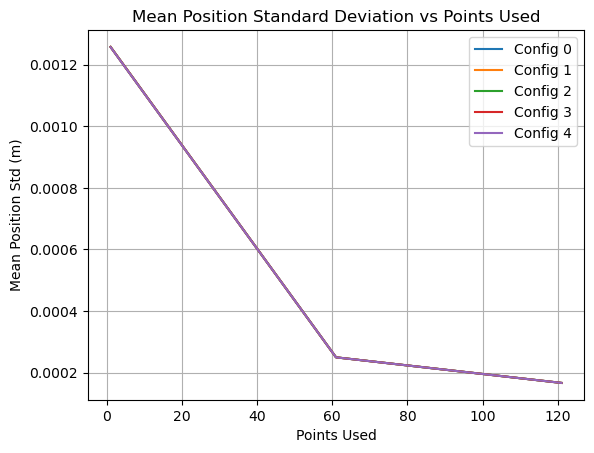

In [42]:
for idx, data in results.items():
    plt.plot(data['ranges_used'], data['out_of_plane'], label=f'Config {idx}')

plt.title('Mean Position Standard Deviation vs Points Used')
plt.xlabel('Points Used')
plt.ylabel('Mean Position Std (m)')
plt.legend()
plt.grid(True)
plt.show()


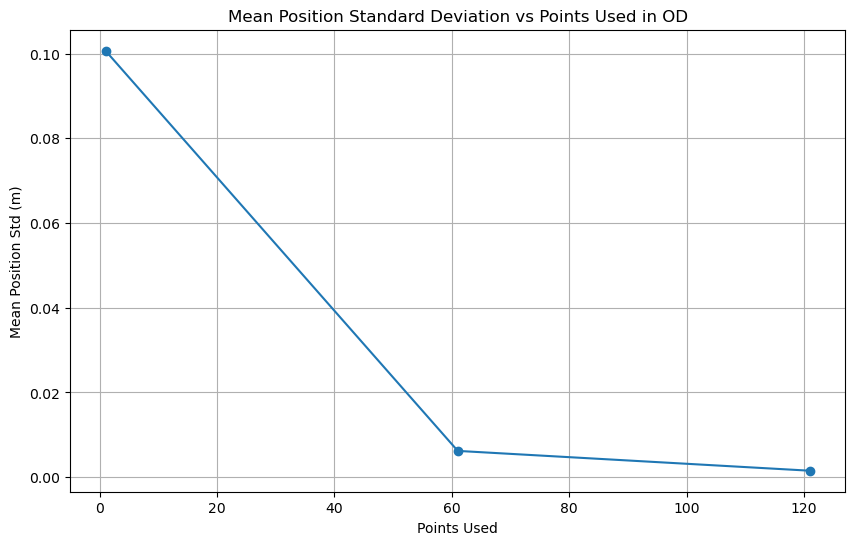

In [34]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(ranges_used[:], mean_pos_std_list[:], marker='o', linestyle='-')
plt.title('Mean Position Standard Deviation vs Points Used in OD')
plt.xlabel('Points Used')
plt.ylabel('Mean Position Std (m)')
plt.grid(True)
plt.show()


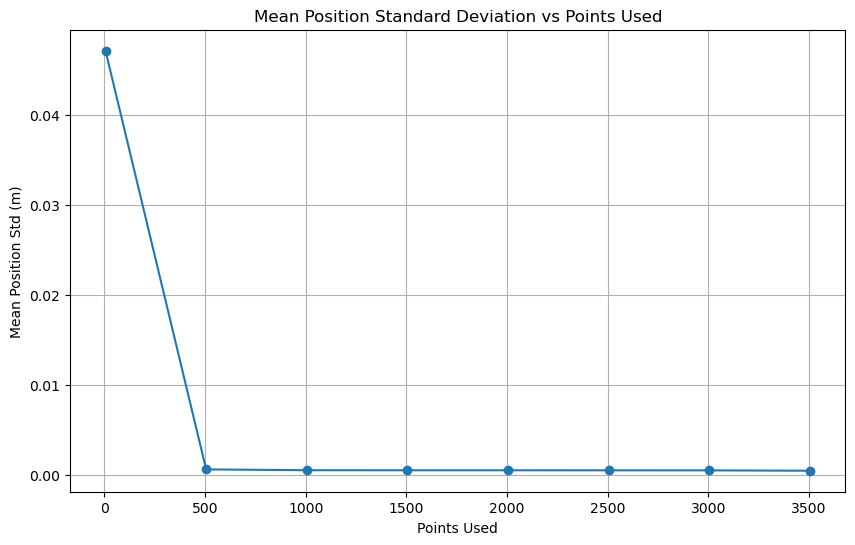

In [17]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(points_to_use_list[:], mean_pos_std_list[:], marker='o', linestyle='-')
plt.title('Mean Position Standard Deviation vs Points Used')
plt.xlabel('Points Used')
plt.ylabel('Mean Position Std (m)')
plt.grid(True)
plt.show()
a

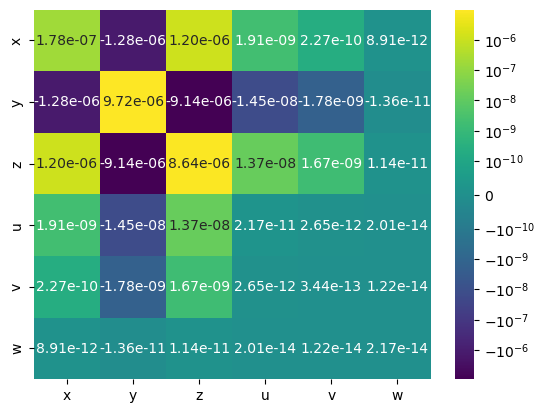

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
labels = ['x', 'y', 'z', 'u', 'v', 'w']
from matplotlib.colors import SymLogNorm
log_norm = SymLogNorm(linthresh=1e-10, vmin=covarianceMat_eci.min(), vmax=covarianceMat_eci.max())
sns.heatmap(covarianceMat_eci, annot=True, fmt=".2e", xticklabels=labels, yticklabels=labels, cmap="viridis", norm=log_norm)
plt.show()

Position std: cross-track 2.094e-03 m, along-track 1.386e-01 m, out-of-plane 5.963e-04 m
Velocity std: cross-track 1.504e-04 m/s, along-track 1.629e-06 m/s, out-of-plane 5.214e-07 m/s


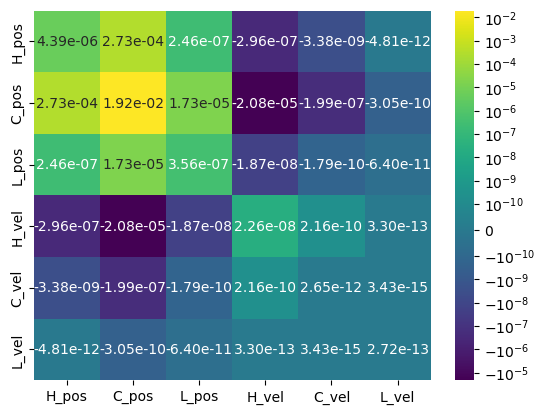

In [48]:
pos_std_crossTrack = np.sqrt(covarianceMat_lvlh[0,0])
pos_std_alongTrack = np.sqrt(covarianceMat_lvlh[1,1])
pos_std_outOfPlane = np.sqrt(covarianceMat_lvlh[2,2])
print(f'Position std: cross-track {pos_std_crossTrack:.3e} m, along-track {pos_std_alongTrack:.3e} m, out-of-plane {pos_std_outOfPlane:.3e} m')

vel_std_crossTrack = np.sqrt(covarianceMat_lvlh[3,3])
vel_std_alongTrack = np.sqrt(covarianceMat_lvlh[4,4])
vel_std_outOfPlane = np.sqrt(covarianceMat_lvlh[5,5])
print(f'Velocity std: cross-track {vel_std_crossTrack:.3e} m/s, along-track {vel_std_alongTrack:.3e} m/s, out-of-plane {vel_std_outOfPlane:.3e} m/s')

# Position std: cross-track 9.030e-02 m, along-track 3.719e-01 m, out-of-plane 2.267e-01 m
# Velocity std: cross-track 3.581e-04 m/s, along-track 9.809e-05 m/s, out-of-plane 2.741e-04 m/s

#plot a heatmap of the covariance matrix, and include the values in the plot

import seaborn as sns
import matplotlib.pyplot as plt
labels = ['H_pos', 'C_pos', 'L_pos', 'H_vel', 'C_vel', 'L_vel']
from matplotlib.colors import SymLogNorm
log_norm = SymLogNorm(linthresh=1e-10, vmin=covarianceMat_lvlh.min(), vmax=covarianceMat_lvlh.max())
sns.heatmap(covarianceMat_lvlh, annot=True, fmt=".2e", xticklabels=labels, yticklabels=labels, cmap="viridis", norm=log_norm)
plt.show()


In [ ]:
#### 
# Next steps:
# do POD with only monopole force model
# do POD with good force model but no ERP
# do POD with good force model and Knocke ERP
# do POD with good force model and CERES ERP
# Try different approaches to estimation: batch, Kalman, etc.